# 11-13. 프로젝트: 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

## Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용하세요.  
[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

아래의 코드로 데이터를 다운로드 할 수 있어요.

In [1]:
import pandas as pd

In [2]:
import urllib.request
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
52660,Spider species named after characters in Harry...,Scientists have named seven new spider species...
43264,Rahul Gandhi's hatred for India astonishing: S...,After Rahul Gandhi took a jibe at Centre's Goo...
19780,Indian economist appointed UNEP Assistant Secr...,"Satya Tripathi, an Indian development economis..."
89603,Disha Patani sports a bikini on the cover of C...,Actress Disha Patani has featured on the cover...
26541,Real Madrid will always be his home: Club on R...,Following Cristiano Ronaldo's transfer from Re...
11810,Crashed plane suffered glitch on a previous fl...,An Indonesian passenger plane carrying 189 peo...
37735,Bihar CM Nitish gets Supreme Court notice for ...,The Supreme Court has issued a notice to Bihar...
31134,Touching experience: CSK's Lungi on training a...,Chennai Super Kings' fast bowler Lungi Ngidi t...
78073,Chapecoense air crash survivor to play vs BarÃ...,"Brazilian footballer Alan Ruschel, who survive..."
24824,Ex-delivery boy partners Amazon employee to ch...,Amazon India's ex-delivery boy partnered with ...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from bs4 import BeautifulSoup
import urllib.request
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj61/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
print(f'전체 샘플수: {len(data)}')

전체 샘플수: 98401


## Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

### 데이터 정리하기

#### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [10]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


text의 중복 샘플을 제거합니다.

In [11]:
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [12]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### 텍스트 정규화와 불용어 제거

In [14]:
# 텍스트 정규화를 위한 사전
contractions = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [16]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence)  # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence)  # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [18]:
clean_text = []

# 전체 text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [19]:
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [20]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [21]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [22]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 훈련데이터와 테스트데이터 나누기

#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


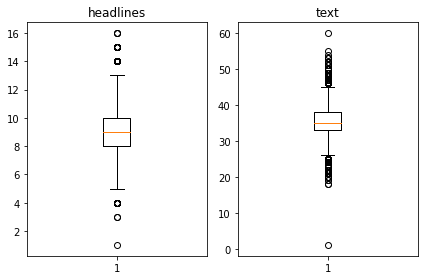

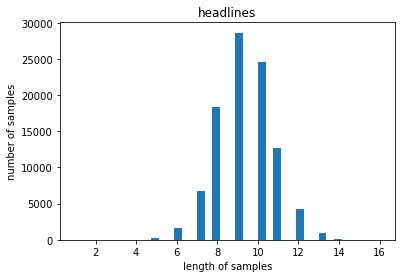

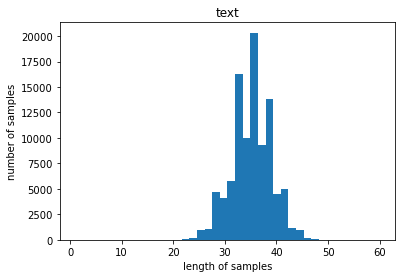

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1, 2, 1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1, 2, 2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
text_max_len = 45
headlines_max_len = 13

In [25]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' %
          (max_len, (cnt / len(nested_list))))

In [26]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [27]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97863


#### 시작 토큰과 종료 토큰 추가하기

In [28]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [29]:
encoder_input = np.array(data['text'])  # 인코더의 입력
decoder_input = np.array(data['decoder_input'])  # 디코더의 입력
decoder_target = np.array(data['decoder_target'])  # 디코더의 레이블

In [30]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[15397 60118 84975 ... 68075 74239 12259]


In [31]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [32]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19572


In [33]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


### 정수 인코딩

#### 단어 집합 만들기 및 정수 인코딩

In [34]:
src_tokenizer = Tokenizer()  # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train)  # 입력된 데이터로부터 단어 집합 생성

In [35]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)  # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69372
등장 빈도가 6번 이하인 희귀 단어의 수: 47270
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22102
단어 집합에서 희귀 단어의 비율: 68.13988352649484
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4961198145030514


In [36]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab)   # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train)  # 단어 집합 재생성.

In [37]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[409, 72, 617, 10220, 19454, 2678, 261, 3025, 1871, 2637, 9838, 505, 16651, 78, 317, 944, 60, 1375, 19454, 83, 3769, 14754, 9838, 2317, 2, 384, 73, 2733, 1368, 409, 9838, 2, 9094, 326, 81, 1124, 621, 2, 78], [4346, 4486, 969, 1579, 4161, 267, 712, 399, 803, 308, 13308, 117, 317, 7646, 60, 139, 1423, 267, 19455, 96, 641, 224, 5850, 169, 308, 450, 2938, 308, 11217, 399, 1112, 256, 3586, 3822], [411, 128, 2, 153, 734, 806, 220, 13309, 1325, 714, 764, 146, 10221, 1266, 1775, 5534, 153, 985, 399, 3010, 13309, 117, 1325, 6, 4, 10221, 1129, 1581, 262, 1250, 1266, 2418]]


In [38]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [41]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)  # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30017
등장 빈도가 5번 이하인 희귀 단어의 수: 19616
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10401
단어 집합에서 희귀 단어의 비율: 65.3496352067162
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.660064711739743


In [42]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ', decoder_input_train[:5])
print('target')
print('decoder ', decoder_target_train[:5])

input
input  [[1, 207, 6164, 1982, 6466, 8168, 14, 719, 12, 191], [1, 2779, 214, 3014, 3760, 1459, 208, 12, 191], [1, 103, 8, 316, 7655, 847, 45, 8757, 3, 474, 801], [1, 83, 78, 15, 9483, 813, 2073, 424, 85], [1, 103, 8, 214, 217, 1162, 7, 164, 119, 99, 957, 1882]]
target
decoder  [[207, 6164, 1982, 6466, 8168, 14, 719, 12, 191, 2], [2779, 214, 3014, 3760, 1459, 208, 12, 191, 2], [103, 8, 316, 7655, 847, 45, 8757, 3, 474, 801, 2], [83, 78, 15, 9483, 813, 2073, 424, 85, 2], [103, 8, 214, 217, 1162, 7, 164, 119, 99, 957, 1882, 2]]


In [43]:
drop_train = [index for index, sentence in enumerate(
    decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(
    decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


/home/aiffel-dj61/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩하기

In [44]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

### 모델 설계하기

In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True,
                     return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True,
                     return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True,
                     return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [46]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True,
                    return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [47]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [48]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [49]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [50]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, validation_data=(
    [encoder_input_test, decoder_input_test], decoder_target_test), batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 111s 363ms/step - loss: 5.2324 - val_loss: 4.8747
Epoch 2/50
306/306 [==============================] - 111s 362ms/step - loss: 4.6779 - val_loss: 4.4424
Epoch 3/50
306/306 [==============================] - 111s 364ms/step - loss: 4.3418 - val_loss: 4.2101
Epoch 4/50
306/306 [==============================] - 111s 362ms/step - loss: 4.1014 - val_loss: 4.0297
Epoch 5/50
306/306 [==============================] - 111s 362ms/step - loss: 3.9130 - val_loss: 3.9044
Epoch 6/50
306/306 [==============================] - 111s 363ms/step - loss: 3.7555 - val_loss: 3.7992
Epoch 7/50
306/306 [==============================] - 111s 363ms/step - loss: 3.6165 - val_loss: 3.7074
Epoch 8/50
306/306 [==============================] - 111s 363ms/step - loss: 3.4978 - val_loss: 3.6404
Epoch 9/50
306/306 [==============================] - 114s 372ms/step - loss: 3.3948 - val_loss: 3.5809
Epoch 10/50
306/306 [==============================] - 114s 372m

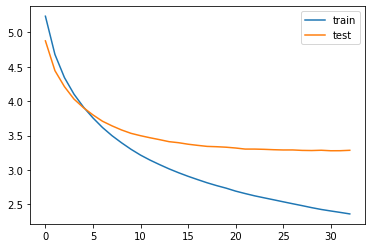

In [51]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [52]:
src_index_to_word = src_tokenizer.index_word  # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index  # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word  # 요약 단어 집합에서 정수 -> 단어를 얻음

In [53]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[
                      encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [54]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer(
    [decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(
    axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,
                        decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [55]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:  # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token != 'eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

### 모델 테스트하기

In [57]:
def seq2text(input_seq):
    '''원문의 정수 시퀀스를 텍스트 시퀀스로 변환'''
    temp = ''
    for i in input_seq:
        if(i != 0):
            temp = temp + src_index_to_word[i]+' '
    return temp


def seq2headlines(input_seq):
    '''요약문의 정수 시퀀스를 텍스트 시퀀스로 변환'''
    temp = ''
    for i in input_seq:
        if((i != 0 and i != tar_word_to_index['sostoken']) and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [58]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(
        encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : alleging ndtv founder prannoy roy may escape south africa bjp parliamentarian subramanian swamy said asking ed department issue look notice roy last year cbi accused roy causing losses icici bank meanwhile roy written pmo swamy malicious campaign ndtv 
실제 요약 : ndtv founder prannoy roy may from india swamy 
예측 요약 :  founders quit snapdeal over unpaid scam swamy


원문 : supreme court rejected mining baron janardhana reddy plea campaigning brother bjp candidate city karnataka elections janardhana charged crore mining scam barred bail condition sc also prohibited casting vote 
실제 요약 : mining scam charged reddy brother cannot campaign for bjp sc 
예측 요약 :  sc dismisses pil seeking protection to vote in taka polls


원문 : puducherry lieutenant governor kiran bedi hit back union territory leaders saying work falls responsibility designated lg well administrator said adding elected representatives refused cooperate efforts puducherry assembly recently passed resolution limiting powers 
실제 요약

예측 요약 :  astronaut shares selfie with astronauts at space station


원문 : two bjp mps hari narayan rajbhar verma demanded commission set examine complaints men suffering hands wives due alleged misuse laws however national commission women said people right demand commission men need body 
실제 요약 : bjp mps demand panel for men suffering at hands of wives 
예측 요약 :  bjp mps to work with mps after sc order on journalists


원문 : congress posters bihar patna show party president rahul gandhi leaders state party unit castes labelled rahul labelled brahmin leaders castes like dalit rajput printed photographs posters thank rahul party leader gohil setting example social harmony 
실제 요약 : posters in patna mention of rahul other cong leaders 
예측 요약 :  rjd expels rahul gandhi statue of rahul gandhi


원문 : congress social media head divya spandana took twitter troll bjp decreasing value indian currency saying cricketer kedar jadhav bowling action low still low value rupee responding divya tweet bjp k

예측 요약 :  have been in my life ayushmann khurrana


원문 : australian tennis player nick kyrgios fined caught seemingly simulating masturbation water bottle match london year old world number seen shaking bottle spraying water making facial expressions tv channel airing match forced issue air apology 
실제 요약 : tennis player masturbation with bottle fined 
예측 요약 :  nadal fined lakh for foot tall drink in bottle


원문 : jammu kashmir governor satya pal malik said killed bjp leader anil brother ajit identified brought public soon added killings carried militants frustration urban local body elections completed without killings 
실제 요약 : killer of bjp leader his brother identified governor 
예측 요약 :  bjp leader who was my brother governor


원문 : gujarat board class sanskrit textbook introduction sanskrit language claims hindu mythology epic ramayana sita abducted ram instead ravana heart touching description message conveyed laxman ram sita abducted rama line book read however official said trans

## Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [61]:
import requests
import numpy as np
from summa.summarizer import summarize
from summa.keywords import keywords

In [62]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [69]:
data['summa_headlines'] = data['headlines']

In [70]:
for i in range(len(data)):
    data['summa_headlines'][i] = summarize(data['text'][i])

data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines              0
text                   0
summa_headlines    97593
dtype: int64

In [71]:
data.dropna(axis=0, inplace=True)

In [72]:
len(data)

808

In [74]:
pd.DataFrame(data['summa_headlines'].sample(5))

,summa_headlines
10962,And for a bank which is present in USA we will...
17258,Congress chief Rahul Gandhi has claimed that t...
1765,"India wicketkeeper-batsman Rishabh Pant, who w..."
87510,'Sachin: A Billion Dreams' which released on F...
71952,"Rapper-record producer Jay Z, during his perfo..."


In [80]:
for i in range(5):
    print("원문 :", data['text'].iloc[i])
    print("실제 헤드라인 :", data['headlines'].iloc[i])
    print("추출 요약 :", data['summa_headlines'].iloc[i])
    print("\n")

원문 : Former Australia batsman Mark Waugh called former New Zealand captain and Brisbane Heat batsman Brendon McCullum a "lucky c**t" during a Big Bash League chat show on live TV. Waugh was talking about McCullum's favourite hobby outside of cricket, horse racing, when he uttered the word. "He loves his horses. Good punter. He's a lucky c***...lucky punter too," Waugh said.
실제 헤드라인 : Mark Waugh calls Brendon McCullum a 'lucky c**t' on live TV
추출 요약 : He's a lucky c***...lucky punter too," Waugh said.


원문 : Vedanta Resources Founder and Chairman Anil Agarwal said he won't retire soon and added the conglomerate's growth requires his "aggression" and "risk-taking" ability. "Why should I hang [my boots]. I have a task [to finish]," he said. "Nobody can think of producing [5,00,000] barrels oil in such a short time... you [must] take the bull by the horn," he added.  
실제 헤드라인 : Won't retire soon, Vedanta needs my aggression: Chairman
추출 요약 : Vedanta Resources Founder and Chairman Anil Agar

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|:---|:---|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

## 후기

코드를 따라 돌려보는 것은 충분히 좋은 경험인데, 하나하나 뜯어 살펴 공부할 시간이 부족합니다.  
뭔가 체계적으로 공부가 되지 않는 느낌이네요.